# Chatbot with Memory

## Review

[Memory](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/) is a cognitive function that allows people to store, retrieve, and use information to understand their present and future. 

There are [various long-term memory types](https://langchain-ai.github.io/langgraph/concepts/memory/#memory) that can be used in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.
 
We'll focus on long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory), which will be facts about the user. 

These long-term memories will be used to create a personalized chat bot that can remember facts about the user.

It will save memory ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

In [22]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Introduction to the LangGraph Store

The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [3]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by `namespace`.

This returns a list.

In [4]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [5]:
# Metatdata 
memories[0].dict()

{'value': {'food_preference': 'I like pizza'},
 'key': 'd1985281-b3a5-481b-8c61-fec585f9322a',
 'namespace': ['1', 'memories'],
 'created_at': '2024-10-28T16:11:31.800043+00:00',
 'updated_at': '2024-10-28T16:11:31.800045+00:00'}

In [6]:
# The key, value
print(memories[0].key, memories[0].value)

d1985281-b3a5-481b-8c61-fec585f9322a {'food_preference': 'I like pizza'}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [7]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'food_preference': 'I like pizza'},
 'key': 'd1985281-b3a5-481b-8c61-fec585f9322a',
 'namespace': ['1', 'memories'],
 'created_at': '2024-10-28T16:11:31.800043+00:00',
 'updated_at': '2024-10-28T16:11:31.800045+00:00'}

## Chatbot with long-term memory

We want a chatbot that [has two types of memory](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156):

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

In [10]:
_set_env("OPENAI_API_KEY")

For `short-term memory`, we'll use a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

See Module 2 and our [conceptual docs](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more on checkpointers, but in summary:

* They write the graph state at each step to a thread.
* They persist the chat history in the thread.
* They allow the graph to be interrupted and / or resumed from any step in the thread.
 
And, for `long-term memory`, we'll use the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as introduced above.

In [1]:
# Chat model 
from langchain_openai import ChatOpenAI

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

The chat history will be saved to short-term memory using the checkpointer.

The chatbot will reflect on the chat history. 

It will then create and save a memory to the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore).

This memory is accessible in future chat sessions to personalize the chatbot's responses!

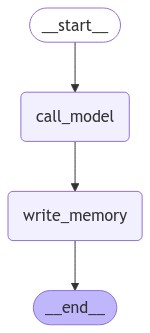

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memory in the system prompt
    system_msg = f"""You are a helpful assistant with memory that provides information about the user. 
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {existing_memory.value if existing_memory else None}"""

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Create new memory from the chat history and existing memory
    system_msg = f"""Create or update a memory that captures information about the user based on the following chat history. 
    This will be saved for long-term memory. If there is an existing memory, simply update it with the new information.
    Here is the existing memory (it may be empty): {existing_memory.value if existing_memory else None}"""
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice. 

In [6]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [7]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [8]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


Recall that we compiled the graph with our the store: 

```python
across_thread_memory = InMemoryStore()
```

And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [9]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': 'Updated memory: Lance has introduced himself and enjoys biking around San Francisco.'},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-10-28T23:00:50.895734+00:00',
 'updated_at': '2024-10-28T23:00:54.819559+00:00'}

Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [10]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Lance! Since you enjoy biking around San Francisco, I recommend checking out the Golden Gate Park for a scenic and leisurely ride. You could also try the Marin Headlands for a more challenging route with stunning views of the Golden Gate Bridge and the city. If you're up for a longer ride, the Bay Trail offers a great path along the waterfront. Enjoy your ride!


In [11]:
# User input 
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out. I like a croissant after biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out. I like a croissant after biking?
================================== Ai Message ==================================

Absolutely, Lance! After a nice ride, you might want to stop by Arizmendi Bakery on 9th Avenue near Golden Gate Park. They have delicious croissants and other baked goods. Another great option is Tartine Bakery in the Mission District, known for their amazing pastries. If you're near the Marina after biking the Marin Headlands, Le Marais Bakery is a fantastic spot for a croissant. Enjoy your treat!


In [12]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': 'Updated memory: Lance has introduced himself and enjoys biking around San Francisco. He is seeking recommendations for biking routes. He also likes to have a croissant after biking and is interested in nearby bakeries.'},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-10-28T23:00:50.895734+00:00',
 'updated_at': '2024-10-28T23:03:35.882674+00:00'}

## Viewing traces in LangSmith

We can see that the memories are retrieved from the store and supplied as part of the system prompt, as expected:

https://smith.langchain.com/public/91764d87-7ab7-44f3-b0f3-b161d1132c9f/r

## Studio

We can also interact with our chatbot in Studio. 

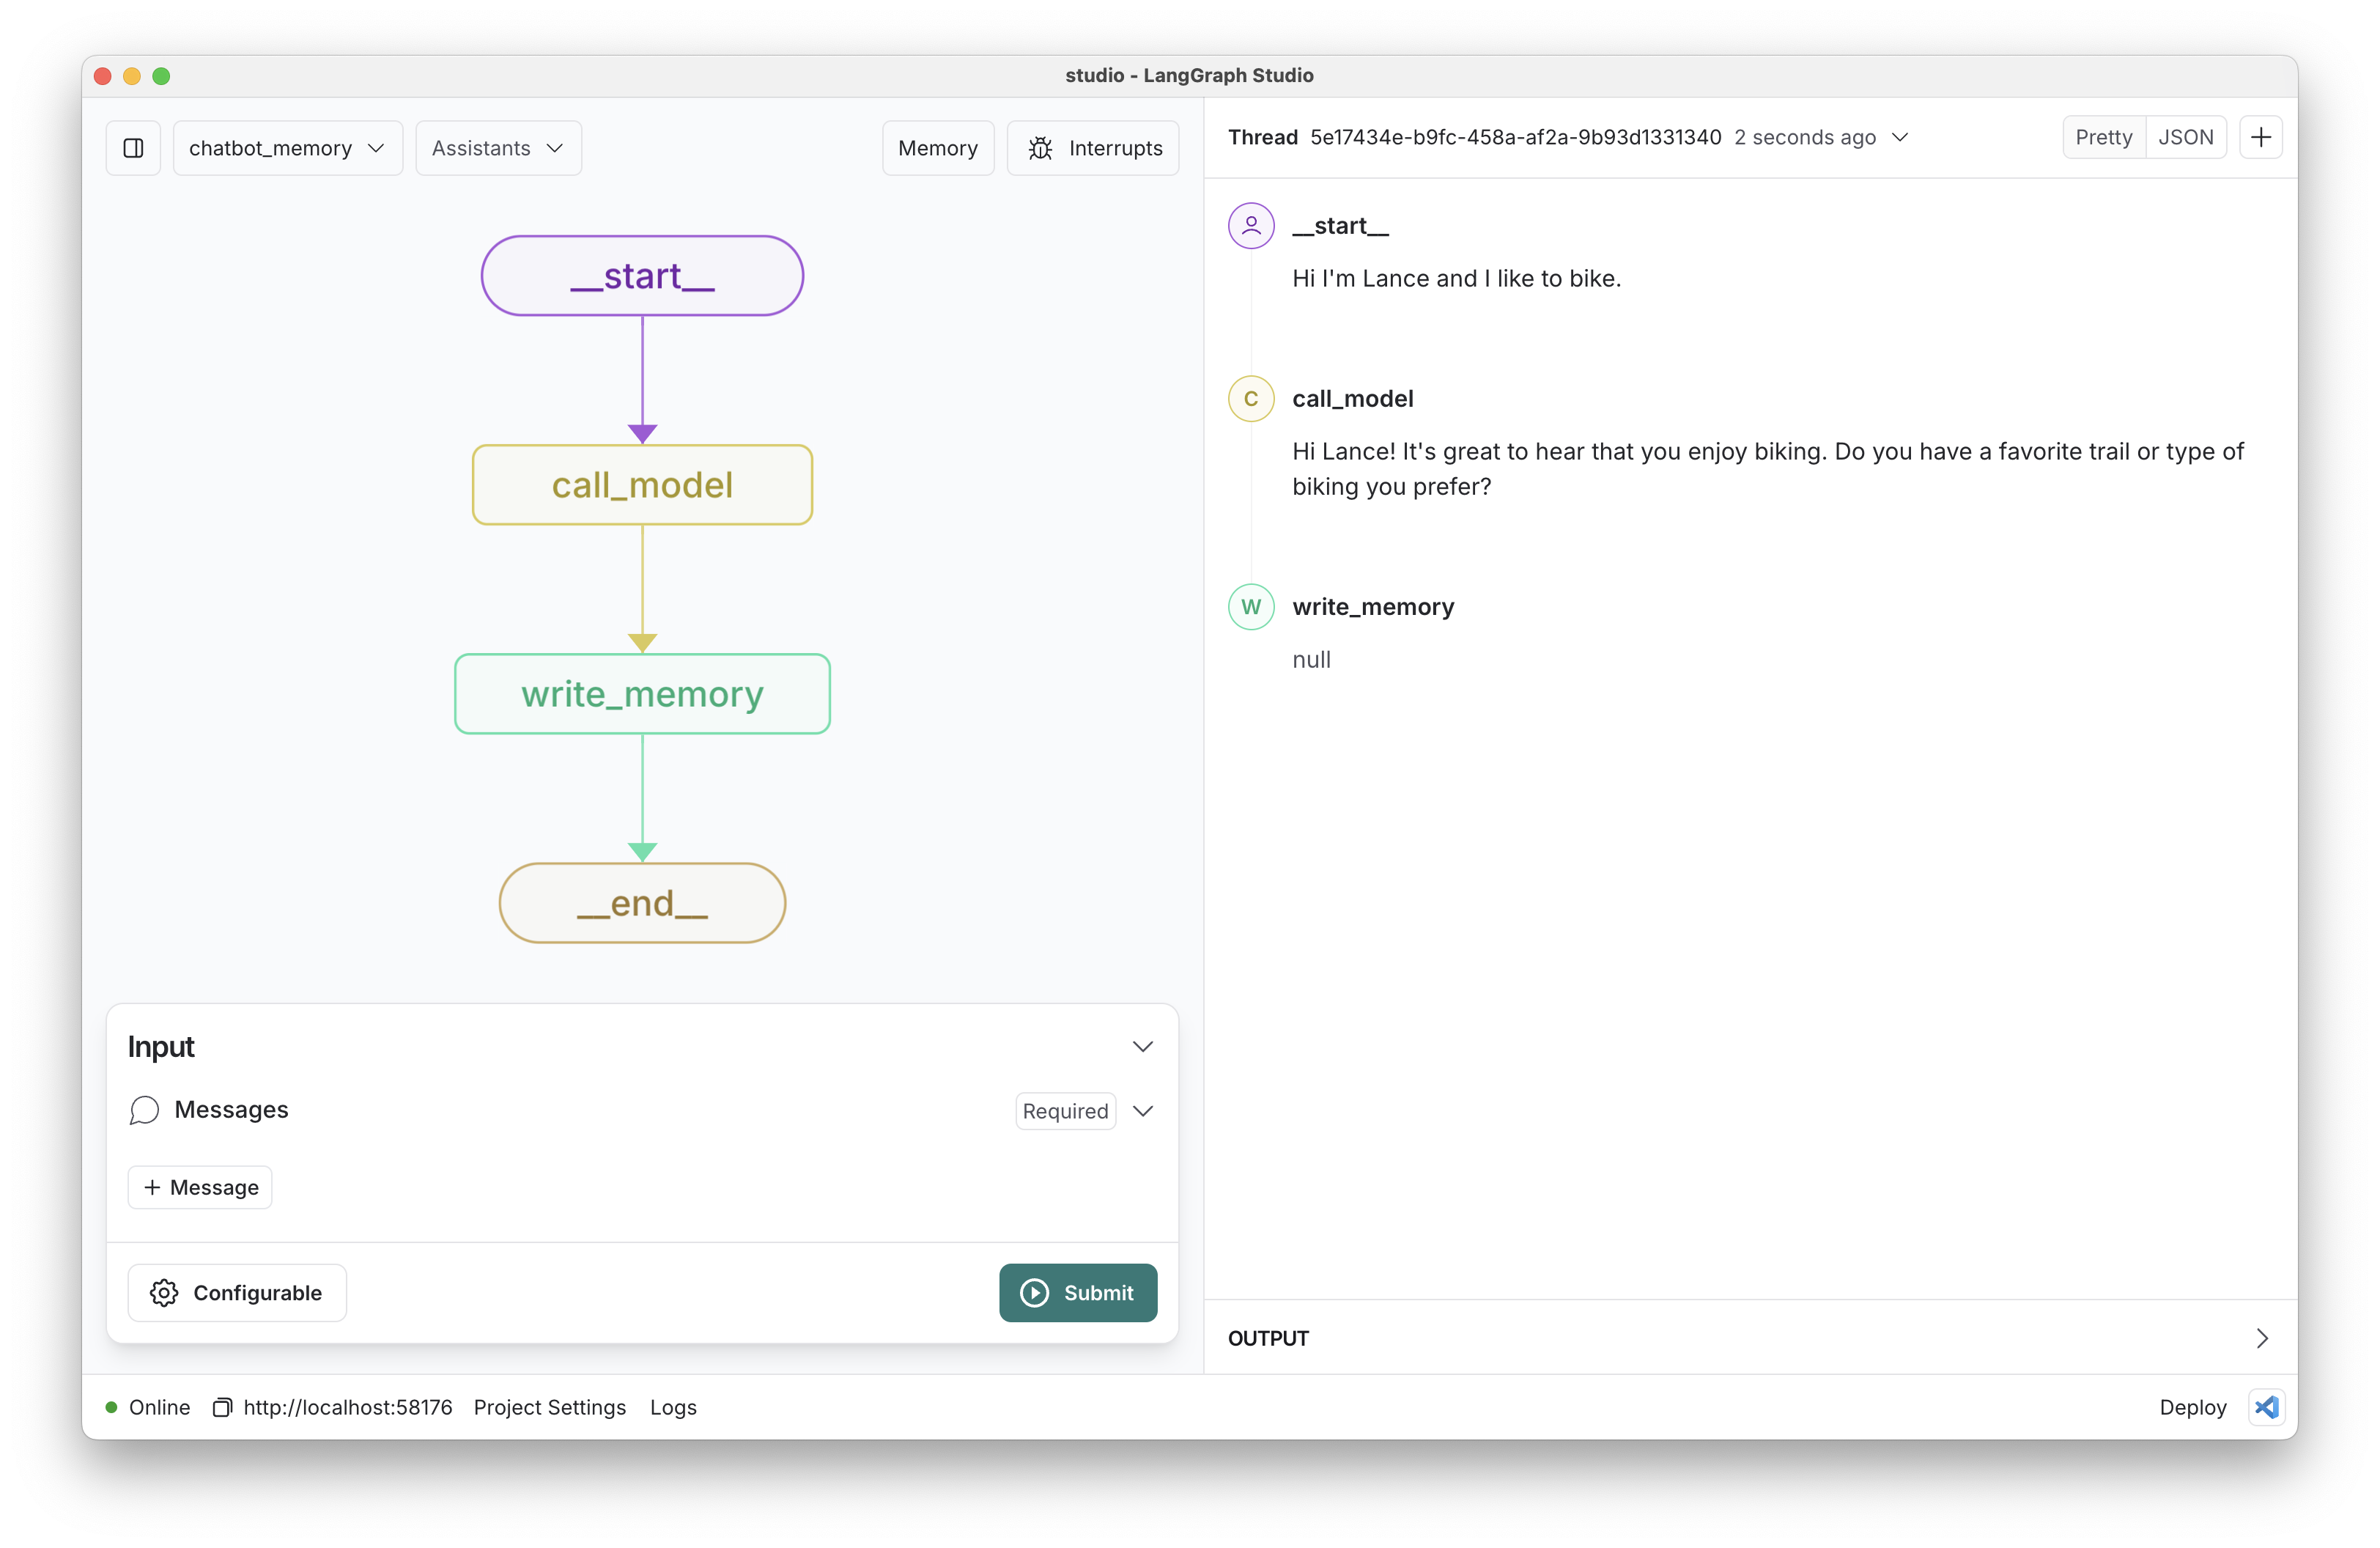

The `Store` is built-into the LangGraph API, so it's accessible to us in Studio scoped to each project. 

Studio has a `Memories` tab that allows us to see memories that are saved to the `Store`.

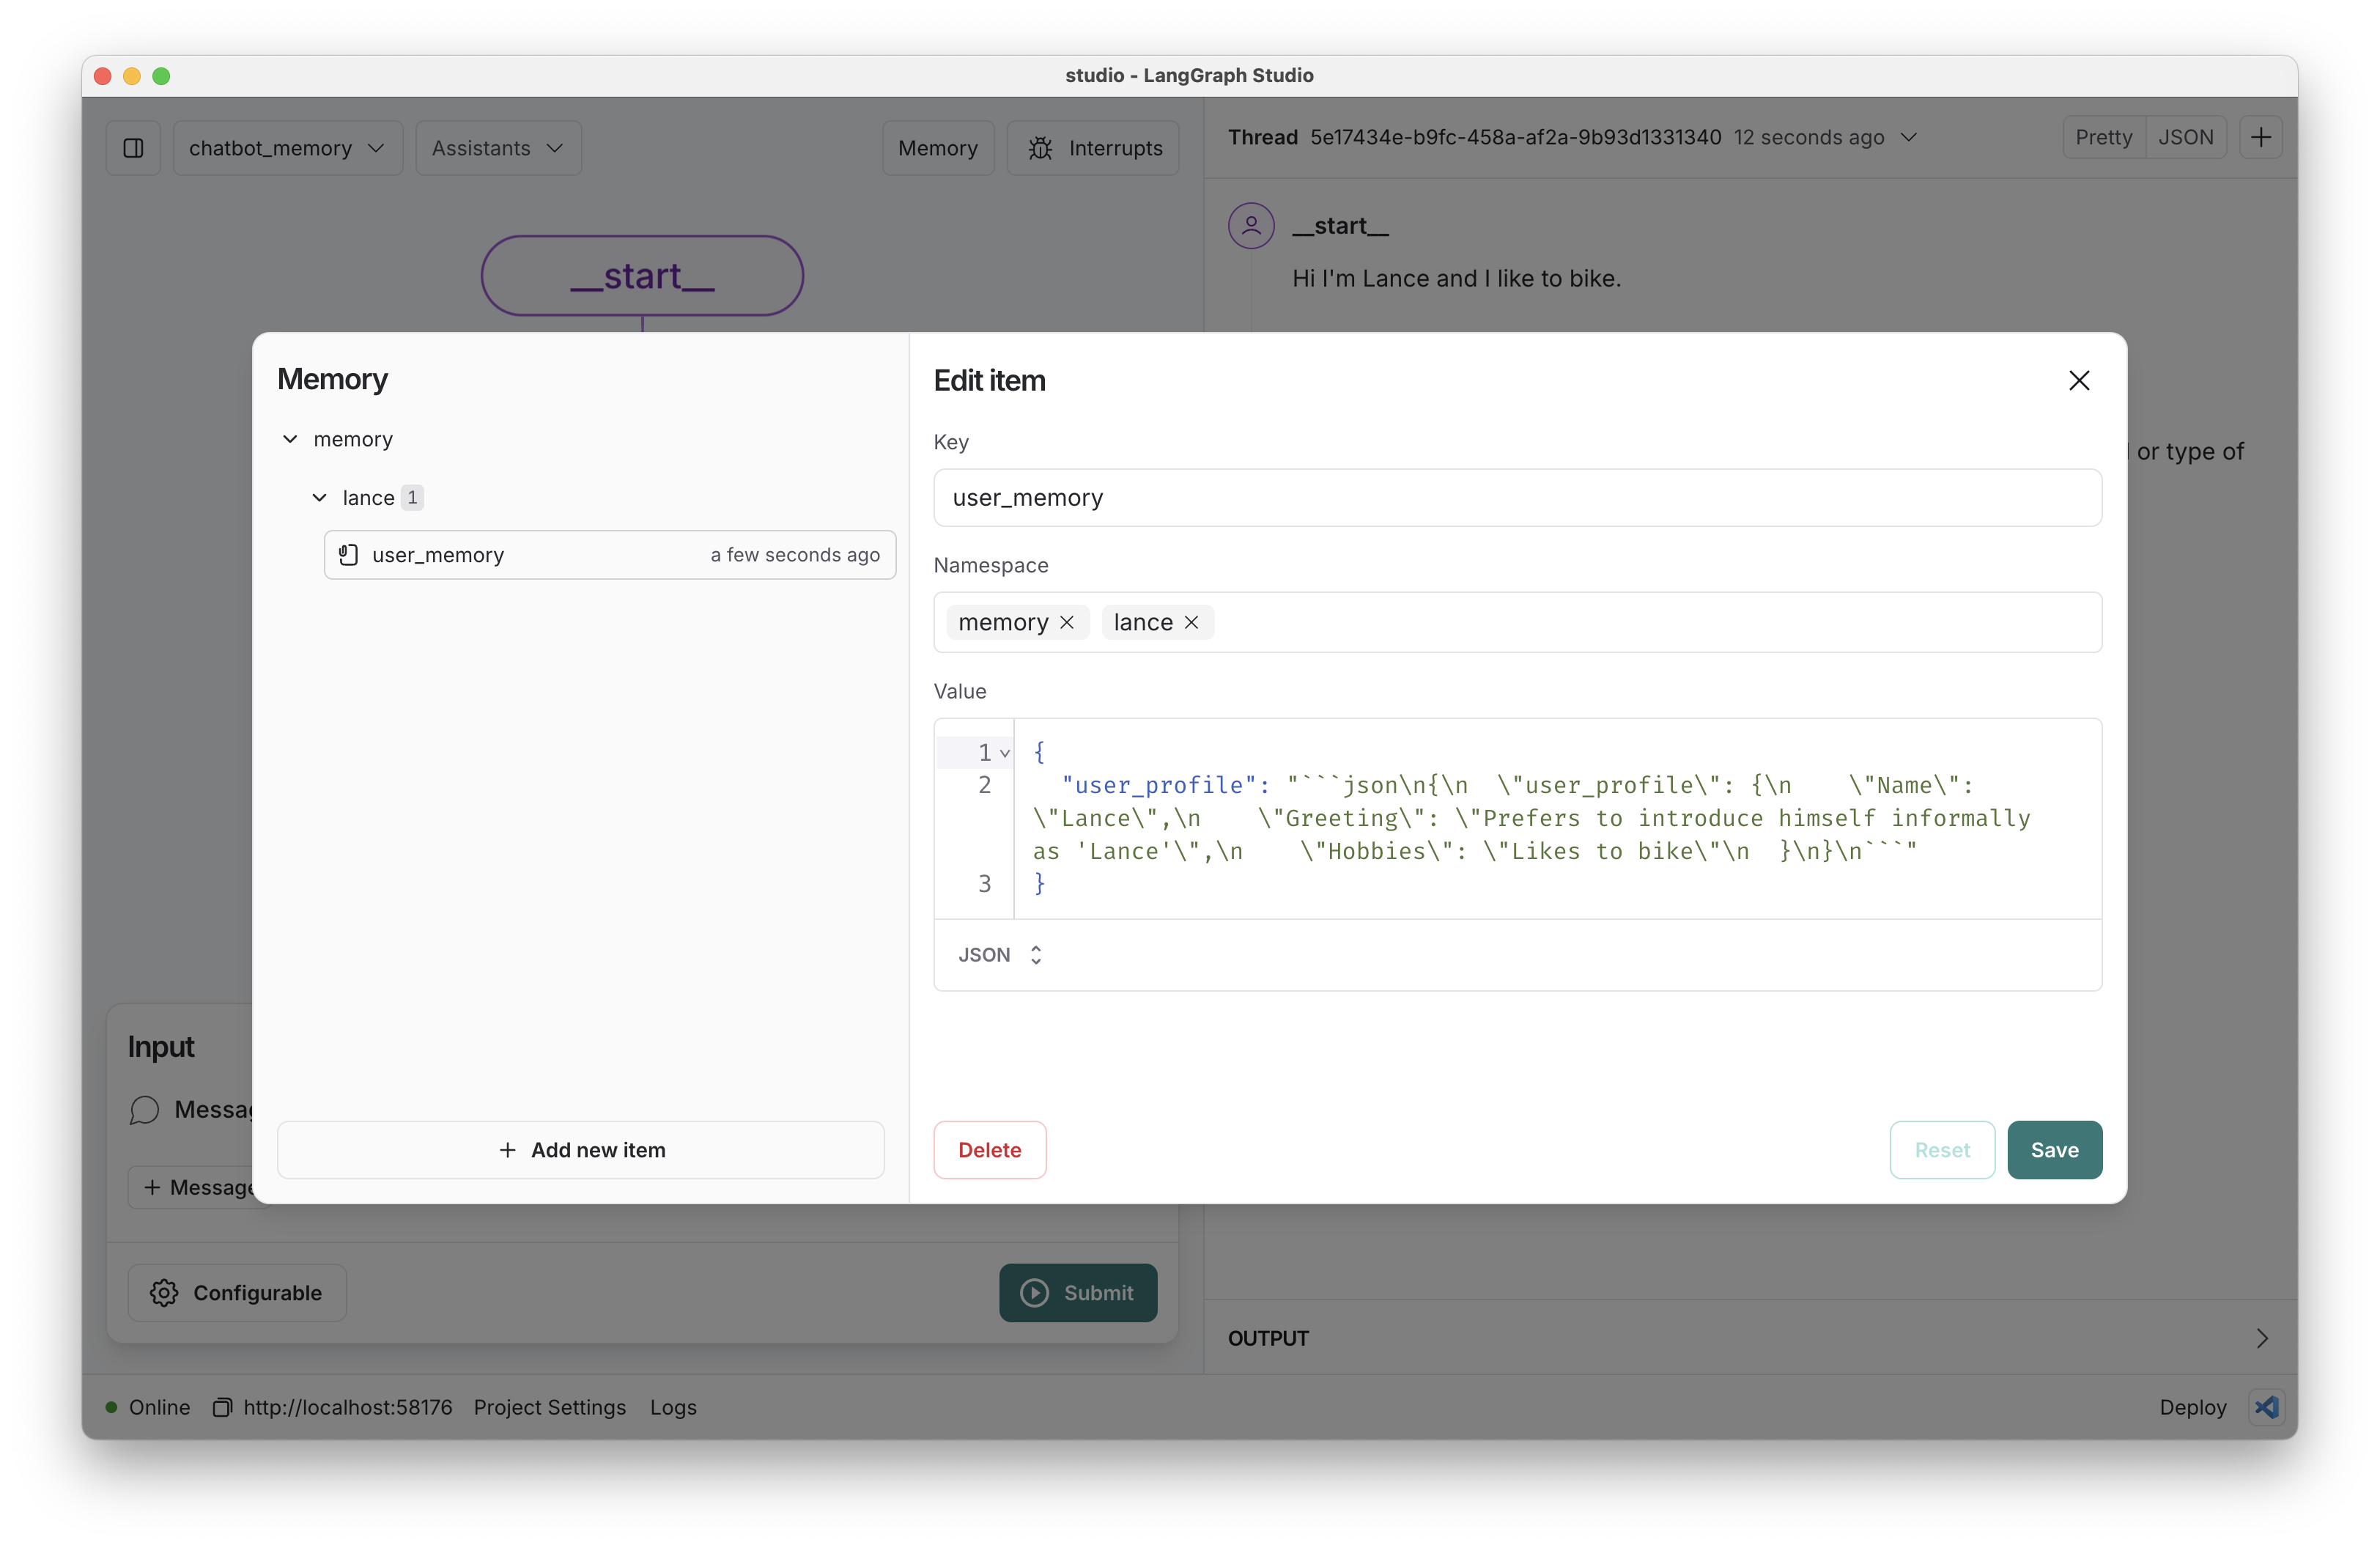